<a href="https://colab.research.google.com/github/yiwenwangANU/Tensorflow_Certificate/blob/main/Tensorflow_Certificate_Callbacks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras import layers

#Model

In [13]:
X = np.arange(-100, 100, 4)
y = np.arange(-90, 110, 4)

X = tf.expand_dims(X, axis=-1)
X_train = X[:40] # first 40 examples (80% of data)
y_train = y[:40]

X_test = X[40:] # last 10 examples (20% of data)
y_test = y[40:]

In [43]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(16),
  tf.keras.layers.Dense(1)
], name='model')

# Compile the model
model.compile(loss=tf.keras.losses.mae, # mae is short for mean absolute error
              optimizer=tf.keras.optimizers.SGD(), # SGD is short for stochastic gradient descent
              metrics=["mae"])

In [53]:
history = model.fit(X_train,
          y_train,
          epochs=100,
          validation_data=(X_test, y_test),
          verbose=0)

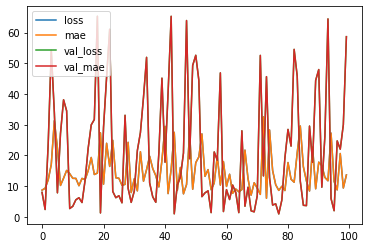

In [55]:
pd.DataFrame(history.history).plot()

In [56]:
model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 61ms/step - loss: 58.6741 - mae: 58.6741


[58.67414474487305, 58.67414474487305]

#Check Point

In [2]:
import os 
def create_model_checkpoint(model_name, save_path="model_checkpoints"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name, ""), 
                                            verbose=0, 
                                            save_weights_only=True,
                                            save_best_only=True)

In [35]:
model.fit(X_train,
          y_train,
          epochs=100,
          validation_data=(X_test, y_test),
          verbose=0,
          callbacks=[create_model_checkpoint(model_name=model.name)])

In [36]:
model.load_weights("model_checkpoints/model/")
model.compile(loss=tf.keras.losses.mae,
                   optimizer=tf.keras.optimizers.SGD(),
                   metrics=['mae'])
model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 197ms/step - loss: 0.9324 - mae: 0.9324


[0.9324081540107727, 0.9324081540107727]

#Early Stopping

In [41]:
model.fit(X_train,
          y_train,
          epochs=100,
          validation_data=(X_test, y_test),
          verbose=0,
          callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                      patience=10,
                                                      restore_best_weights=True),
                     tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                           patience=5,
                                                          #factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                           verbose=1)])


Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 14: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.


In [42]:
model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 25ms/step - loss: 1.3323 - mae: 1.3323


[1.332251787185669, 1.332251787185669]

#Helper Functions

##General

In [57]:
import zipfile

def unzip_data(filename):
  """
  Unzips filename into the current working directory.
  Args:
    filename (str): a filepath to a target zip folder to be unzipped.
  """
  zip_ref = zipfile.ZipFile(filename, "r")
  zip_ref.extractall()
  zip_ref.close()

In [58]:
import os

def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [59]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.
  Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array
  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [51]:
def plot_loss_curves(history): ### using accuracy metrics
  """
  Returns separate loss curves for training and validation metrics.
  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

##Image

In [49]:
import io

def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).
  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.image.decode_jpeg(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return 

In [50]:
import matplotlib.pyplot as plt

def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);